In [141]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 

genSavePath = "F:/PythonProjects/NietoExcercise-1/SavedResults/"
day = "11" # Which month and days result you want to visualize in table
month = 11

repetitionValue = 38
repetitionName =   "testJ1"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBestSeed*")

saveTop = False
if saveTop:
    saveTopName = "top1udrli"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.1
print(len(savedResults))
print(len(savedResults)/9)

90
10.0


In [142]:
import pandas as pd
from array import ArrayType
from requests import delete
from tabulate import tabulate
from prettytable import PrettyTable as pt
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0
nrOfCombination = 0
currSeed = 0
currSubj = 0
combinationList = []
combinationResult = []


results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
for x in range(subjectAmount):
    combinationResult.append([])

nrOfSeedsPerSubject = np.zeros(subjectAmount)
for s, subject in enumerate(results):
    currSubj = 0
    currSeed = 0
    subjectBestArray = np.empty([len(subject)], dtype=object)

    currSeed = subject[0]
    currSubj = subject[1]

    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 6:

                aName = aResults2[0]
                ares = aResults2[1]

                if type(ares) is tuple:
                    ares = ares[0]
                if ares > 0.98:
                    ares = 0.99
                akernel = aResults2[2]
                
                
                # if "lin" in akernel:
                #     continue
                # if "sig" in akernel:
                #     continue
                aC = round(aResults2[3], 2)

                if aName not in nameDict:
                    nameDict[aName] = nrOfNames
                    nrOfNames += 1
                if akernel not in kernelDict:
                    kernelDict[akernel] = nrOfKernel
                    nrOfKernel += 1
                if [nameDict[aName], kernelDict[akernel], aC] not in combinationList:
                    combinationList.append([nameDict[aName], kernelDict[akernel], aC])
                    nrOfCombination += 1

                combNr = combinationList.index(
                    [nameDict[aName], kernelDict[akernel], aC]
                )
                if any(combNr in sublist for sublist in combinationResult[currSubj]):
                    sublist = np.array(combinationResult[currSubj])
                    
                    index = int(np.where(sublist[:, 0] == combNr)[0])

                    combinationResult[currSubj][index][1] = combinationResult[currSubj][
                        index
                    ][1] * (1 - (1 / nrOfSeedsPerSubject[currSubj])) + ares * (
                        1 / nrOfSeedsPerSubject[currSubj]
                    )

                else:

                    combinationResult[currSubj].append([combNr, ares])

                    # If the np array comes from NN results
            else:

                aName = aResults2[0]
                ares = aResults2[1]

                if type(ares) is tuple:
                    ares = ares[0]
                akernel = aResults2[2]
                aLz = round(aResults2[3], 2)
                areg = round(aResults2[4], 2)
                adrp = round(aResults2[5], 2)
                if aName not in nameDict:
                    nameDict[aName] = nrOfNames
                    nrOfNames += 1
                if akernel not in kernelDict:
                    kernelDict[akernel] = nrOfKernel
                    nrOfKernel += 1
                if [
                    nameDict[aName],
                    kernelDict[akernel],
                    aLz,
                    areg,
                    adrp,
                ] not in combinationList:
                    combinationList.append(
                        [nameDict[aName], kernelDict[akernel], aLz, areg, adrp]
                    )
                    nrOfCombination += 1
                # combResult = []
                combNr = combinationList.index(
                    [nameDict[aName], kernelDict[akernel], aLz, areg, adrp]
                )
                if any(combNr in sublist for sublist in combinationResult[currSubj]):
                    sublist = np.array(combinationResult[currSubj])
                  
                    index = int(np.where(sublist[:, 0] == combNr)[0])

                    combinationResult[currSubj][index][1] = combinationResult[currSubj][
                        index
                    ][1] * (1 - (1 / nrOfSeedsPerSubject[currSubj])) + ares * (
                        1 / nrOfSeedsPerSubject[currSubj]
                    )

                else:

                    combinationResult[currSubj].append([combNr, ares])


# Making table

# headers = [f"{x[0]}:{x[1]}:{x[2]}:" for x in combinationList]
headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
nameArray = np.array(list(nameDict))
topPerFeature = np.zeros([10, len(nameDict)])
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, res[0]] = comboAverage[0, res[0]] + res[1]
            comboTotal[0, res[0]] = comboTotal[0, res[0]] + res[1]
            nrOfSubjects[res[0]] += 1
            subjectResultArray[subNr, res[0]] = res[1]
            
            comboName = list(nameDict.keys())[combinationList[res[0]][0]]
            nameIndex = np.where(nameArray == comboName)[0][0]
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = list(nameDict.keys())[combinationList[res[0]][0]]
                kernel = list(kernelDict.keys())[combinationList[res[0]][1]]
                cVal = combinationList[res[0]][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()

            
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()

                dataF = list(nameDict.keys())[combinationList[res[0]][0]]
                kernel = list(kernelDict.keys())[combinationList[res[0]][1]]
                cVal = combinationList[res[0]][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
# Print the table!
comboAverage = comboAverage / nrOfSubjects
print(comboAverage.shape)
print(subjectResultArray.shape)
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




(1, 42)
(10, 42)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,0.455,0.46,0.385,0.495,0.55,0.515,0.515,0.57,0.64,0.45,0.405,0.505,0.889,0.899,0.894,0.883,0.869,0.888,0.6,0.515,0.64,0.955,0.965,0.942,0.932,0.932,0.917,0.81,0.84,0.85,0.425,0.34,0.475,0.913,0.878,0.903,0.815,0.864,0.869,0.76,0.825,0.879
2,0.466667,0.475,0.475,0.55,0.454167,0.454167,0.5,0.470833,0.445833,0.525,0.541667,0.525,0.85,0.85,0.833333,0.832333,0.8625,0.85,0.545833,0.5875,0.633333,0.99,0.986833,0.9555,0.9575,0.9575,0.890667,0.791667,0.779167,0.791667,0.491667,0.5375,0.470833,0.839667,0.853167,0.8615,0.8125,0.795833,0.791667,0.808333,0.770833,0.795833
3,0.511111,0.488889,0.483333,0.45,0.477778,0.5,0.405556,0.422222,0.438889,0.5,0.477778,0.416667,0.661111,0.583333,0.755556,0.583333,0.55,0.633333,0.516667,0.505556,0.511111,0.951556,0.951556,0.925778,0.914667,0.903556,0.892444,0.85,0.85,0.805556,0.405556,0.477778,0.45,0.8,0.727778,0.855556,0.794444,0.788889,0.75,0.833333,0.761111,0.755556
4,0.479167,0.479167,0.470833,0.504167,0.4625,0.5,0.433333,0.4,0.445833,0.533333,0.5375,0.525,0.8875,0.8375,0.865667,0.8125,0.783333,0.8,0.858333,0.8125,0.870833,0.9805,0.983667,0.977333,0.977333,0.973167,0.966833,0.845833,0.816667,0.829167,0.529167,0.529167,0.408333,0.841667,0.783333,0.8,0.8625,0.841667,0.858333,0.920833,0.865667,0.8625
5,0.4125,0.383333,0.404167,0.4125,0.383333,0.341667,0.516667,0.454167,0.475,0.458333,0.4625,0.425,0.916667,0.8125,0.883333,0.857333,0.795833,0.912667,0.7625,0.691667,0.795833,0.99,0.99,0.9805,0.977333,0.976333,0.973167,0.820833,0.783333,0.903167,0.5625,0.483333,0.591667,0.840667,0.8125,0.8365,0.8125,0.858333,0.8625,0.795833,0.7875,0.845833
6,0.513636,0.490909,0.481818,0.418182,0.440909,0.490909,0.381818,0.35,0.386364,0.490909,0.418182,0.513636,0.754545,0.604545,0.727273,0.759091,0.554545,0.821727,0.536364,0.445455,0.522727,0.917182,0.904545,0.937909,0.894455,0.881818,0.903545,0.836364,0.840909,0.845455,0.513636,0.409091,0.427273,0.75,0.6,0.858091,0.745455,0.745455,0.8,0.75,0.754545,0.809091
7,0.516667,0.454167,0.45,0.470833,0.504167,0.516667,0.491667,0.533333,0.525,0.529167,0.458333,0.458333,0.858333,0.8625,0.866667,0.808333,0.7875,0.8125,0.6375,0.4875,0.6,0.962667,0.97,0.950167,0.952167,0.942833,0.941833,0.85,0.858333,0.883333,0.4625,0.4125,0.4125,0.825,0.795833,0.820833,0.832333,0.816667,0.828167,0.849,0.791667,0.816667
8,0.535,0.49,0.53,0.58,0.585,0.55,0.53,0.495,0.46,0.515,0.48,0.48,0.937,0.923,0.918,0.923,0.923,0.923,0.78,0.765,0.8,0.978,0.923,0.964,0.951,0.918,0.927,0.885,0.919,0.927,0.505,0.45,0.46,0.923,0.923,0.923,0.855,0.904,0.923,0.87,0.89,0.913
9,0.4625,0.4125,0.416667,0.529167,0.529167,0.579167,0.483333,0.533333,0.520833,0.508333,0.4875,0.495833,0.8,0.670833,0.733333,0.825,0.766667,0.8375,0.433333,0.4,0.491667,0.942833,0.931333,0.954333,0.858333,0.845833,0.879167,0.8,0.741667,0.833333,0.558333,0.583333,0.620833,0.783333,0.65,0.745833,0.758333,0.720833,0.716667,0.7625,0.745833,0.783333


In [143]:
x = 0

pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
print(nameDictNrs.shape)
#table = pd.DataFrame(nameDictNrs , columns=nameDict.keys())
table = pd.DataFrame(topPerFeature, columns=nameDict.keys())
#display(table)
display(table)
# for names in nameDict.keys():
#     print(names, end="        ")
#     x +=1
#     #print(x)



(1, 14)


,-fftData,-welchData,-dataHR,-dataCorr1d,-dataFFTCV-BC,-dataWCV-BC,-dataHRCV-BC,-fftDataBC,-welchDataBC,-dataHRBC,-gaussianData,-dataGCVBC,-gaussianDataBC,-dataCorr1dBC
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.460000,0.550000,0.640000,0.505000,0.899000,0.888000,0.640000,0.965000,0.932000,0.850000,0.475000,0.913000,0.869000,0.879000
2,0.475000,0.550000,0.500000,0.541667,0.850000,0.862500,0.633333,0.990000,0.957500,0.791667,0.537500,0.861500,0.812500,0.808333
3,0.511111,0.500000,0.438889,0.500000,0.755556,0.633333,0.516667,0.951556,0.914667,0.850000,0.477778,0.855556,0.794444,0.833333
4,0.479167,0.504167,0.445833,0.537500,0.887500,0.812500,0.870833,0.983667,0.977333,0.845833,0.529167,0.841667,0.862500,0.920833
5,0.412500,0.412500,0.516667,0.462500,0.916667,0.912667,0.795833,0.990000,0.977333,0.903167,0.591667,0.840667,0.862500,0.845833
6,0.513636,0.490909,0.386364,0.513636,0.754545,0.821727,0.536364,0.937909,0.903545,0.845455,0.513636,0.858091,0.800000,0.809091
7,0.516667,0.516667,0.533333,0.529167,0.866667,0.812500,0.637500,0.970000,0.952167,0.883333,0.462500,0.825000,0.832333,0.849000
8,0.535000,0.585000,0.530000,0.515000,0.937000,0.923000,0.800000,0.978000,0.951000,0.927000,0.505000,0.923000,0.923000,0.913000
9,0.462500,0.579167,0.533333,0.508333,0.800000,0.837500,0.491667,0.954333,0.879167,0.833333,0.620833,0.783333,0.758333,0.783333


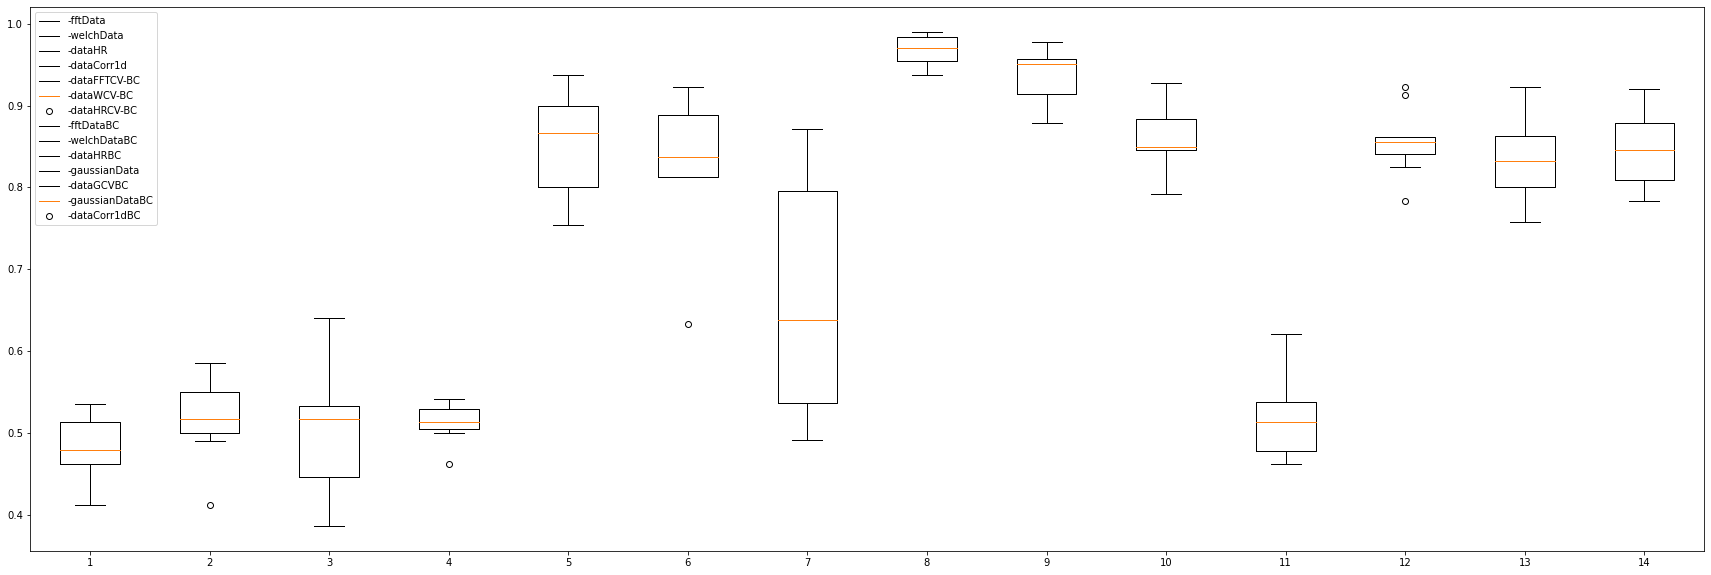

In [144]:
import matplotlib.pyplot as plt
# ordeTopAverage = np.array(np.argsort(comboAverage, axis=1)/(len(combinationList))*len(dataF),dtype=int)
# print(ordeTopAverage)
# print(len(combinationList))
# print(len(dataF))
# print(len(topPerFeature))
# print(len(combinationList)/len(dataF))
#print(ordeTopAverage)

#np.sort(topPerFeature, axis=1)
#np.argsort(comboAverage, axis=1)
#sortA = np.argsort(topPerFeature, axis = 1)
if len(nameArray) < 48:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:])
    plt.legend(nameArray)
    print("")
# else: 
#     plt.figure(figsize=[30,10])
#     fig, ax = plt.subplots(figsize=[30,10])
#     plt.margins(y=1.5)
#     ax.set_ylim([np.min(topPerFeature[1:,ordeTopAverage[0][:topAmount]])-0.3,1])
#     plt.boxplot(topPerFeature[1:,ordeTopAverage[0][:topAmount]])
#     plt.legend(nameArray[ordeTopAverage[0][-topAmount:]])
#     plt.title(f"Best {topAmount} feature combos by average accuracy over subjects")
#     print(nameArray[ordeTopAverage[0][-topAmount:]])
    


In [145]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.99 : subject 5, feature:-fftDataBC, kernelsigmoid, C:2.5
Accuracy 0.99 : subject 5, feature:-fftDataBC, kernellinear, C:2.5
Accuracy 0.99 : subject 2, feature:-fftDataBC, kernellinear, C:2.5
Accuracy 0.99 : subject 2, feature:-fftDataBC, kernelsigmoid, C:2.5
Accuracy 0.98 : subject 4, feature:-fftDataBC, kernelsigmoid, C:2.5
Accuracy 0.98 : subject 5, feature:-fftDataBC, kernelrbf, C:2.5
Accuracy 0.98 : subject 4, feature:-fftDataBC, kernellinear, C:2.5
Accuracy 0.98 : subject 8, feature:-fftDataBC, kernellinear, C:2.5
Accuracy 0.98 : subject 5, feature:-welchDataBC, kernellinear, C:2.5
Accuracy 0.98 : subject 4, feature:-welchDataBC, kernellinear, C:2.5


In [146]:
# top for each feature

In [147]:
print("Top ten highest accuracies")
#del(topThreeThisSubject[0])
#len(topThreeAllSubjects[0])
for subTop in topThreeAllSubjects:
    subTop.reverse()
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects:
    print("")
    #subTop.reverse()
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
#print(arrayOfTopFeatureNames)
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
#print(np.array(arrayOfTopFeatureNames, dtype=object).shape)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    temp = topNames.replace("--","-")
    temp2 = temp.replace("-B","%")
    splitArray = np.array(temp2.split("-"),dtype=object)
    for ind, stri in enumerate(splitArray):
        splitArray[ind] = stri.replace("%","-B")
    skip = False  
    for obj in splitArray:
        #print(obj)
        if obj == "":
            #print("aofafa")
            skip = True
    if skip:
        continue
    #print(splitArray)
    newArrayOfTopFeatureNames.append(splitArray)
    
#print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
#saveTopName = "top2udrli"
if saveTopName is not None:
    #print(newArrayOfTopFeatureNames)
    np.save(saveTopName, newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)


Top ten highest accuracies

Accuracy 0.99 : subject 5, feature:-fftDataBC, kernelsigmoid, C:2.5

Accuracy 0.99 : subject 2, feature:-fftDataBC, kernellinear, C:2.5

Accuracy 0.98 : subject 4, feature:-fftDataBC, kernelsigmoid, C:2.5

Accuracy 0.98 : subject 8, feature:-fftDataBC, kernellinear, C:2.5

Accuracy 0.97 : subject 7, feature:-fftDataBC, kernelsigmoid, C:2.5

Accuracy 0.96 : subject 1, feature:-fftDataBC, kernelsigmoid, C:2.5

Accuracy 0.95 : subject 9, feature:-fftDataBC, kernelrbf, C:2.5

Accuracy 0.95 : subject 3, feature:-fftDataBC, kernelsigmoid, C:2.5

Accuracy 0.94 : subject 6, feature:-fftDataBC, kernelrbf, C:2.5


In [148]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])
# print(headers[maxInd])
# print(nrOfSubjects[maxInd])
# print(list(nameDict.keys())[combinationList[maxInd][0]])
# print(list(kernelDict.keys())[combinationList[maxInd][1]])
# print(f"C: {combinationList[maxInd][2]}")


[0.         0.71692857 0.70614286 0.6504127  0.73220635 0.71528175
 0.64829437 0.70486111 0.76316667 0.6698254 ]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,0.483583,0.459329,0.455202,0.489983,0.487447,0.494175,0.473042,0.469877,0.481973,0.50112,0.474273,0.482719,0.839351,0.782579,0.830796,0.809325,0.76582,0.83097,0.630059,0.578909,0.651723,0.963082,0.956215,0.954169,0.934976,0.925671,0.921295,0.832189,0.825453,0.852075,0.494818,0.469189,0.479604,0.835148,0.780401,0.844924,0.809785,0.815075,0.822148,0.816648,0.799129,0.828979


Max average accuracy 0.9630819304152638


In [149]:
#np.argpartition(comboAverage, -4)
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    print(list(nameDict.keys())[combinationList[maxInd][0]])
    print(list(kernelDict.keys())[combinationList[maxInd][1]])
    print(res)
    print()

-fftDataBC
linear
0.9630819304152638

-fftDataBC
sigmoid
0.9562149270482604

-fftDataBC
rbf
0.9541689113355781

-welchDataBC
linear
0.9349764309764309

-welchDataBC
sigmoid
0.9256711560044896



In [150]:
#np.argpartition(comboAverage, -4)
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(list(nameDict.keys())[combinationList[maxInd][0]])
    print(list(kernelDict.keys())[combinationList[maxInd][1]])
    print(res)
    print()

-fftDataBC
linear
0.9630819304152638

-fftDataBC
sigmoid
0.9562149270482604

-fftDataBC
rbf
0.9541689113355781

-welchDataBC
linear
0.9349764309764309

-welchDataBC
sigmoid
0.9256711560044896



In [151]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:

    # maxInd2 = int(np.where(comboTotal == maxVal2)[1])
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )

    print(list(nameDict.keys())[combinationList[maxInd2][0]])
    print(list(kernelDict.keys())[combinationList[maxInd2][1]])
    print(f"C: {combinationList[maxInd2][2]} ")


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,4.352247,4.133965,4.096818,4.409848,4.38702,4.447576,4.257374,4.228889,4.337753,4.510076,4.26846,4.34447,7.554157,7.043212,7.477162,7.283924,6.892379,7.478727,5.67053,5.210177,5.865505,8.667737,8.605934,8.58752,8.414788,8.33104,8.291657,7.489697,7.429076,7.668677,4.453359,4.222702,4.316439,7.516333,7.023611,7.604313,7.288066,7.335677,7.399333,7.349833,7.192157,7.460813


21
9.0
Max total significant accuracy then averaged 0.9630819304152638 
-fftDataBC
linear
C: 2.5 


In [152]:
# maxAcc = np.max([res for res in np.array(
#     subjectResultArray[subjectResultArray != None])])
# print(f"Max single accuracy position {np.where(subjectResultArray == maxAcc)}")
# print(np.max([res for res in np.array(
#     subjectResultArray[subjectResultArray != None])]))
